# Decision Trees for Mortgage Application Classification
We will show a very simple classification model for this problem: Decision Trees. Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

The steps to be taken are the most usual in an ML model development:

- Loading the datasets
- Preprocesing the data
    - Deleting non relevant columns
    - Filling missing values
    - Enconde the categorical variables
- Training a classification model
- Evaluating the model
- Showing some results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

%matplotlib inline

## Read training and test data
We will read a traiing dataset, a test/validation dataset and a dataset produced in a preprocesing step (but not mentioned neither coded in this notebook), the lender level data. Every row or example of our dataset include a lender, it's a categorical variable with a very high cardinality, so we transform it to a more meaningfull variable. The lender level assign a value to a lender based on its ratio of accepted applications. The more ratio of acceptance, the higher lender level

In [2]:
train_data = pd.read_csv('train_values.csv', sep=',', header=0,index_col=0)
train_label = pd.read_csv('train_labels.csv', sep=',', header=0,index_col=0)

test_data = pd.read_csv('test_values.csv', sep=',', header=0,index_col=0)

lender_data = pd.read_csv('Lender_level.csv', sep=',', header=0,index_col=0)

## Data preprocessing

In this step we transform and convert the original dataset into some new columns or datatypes. In this example we are only dealing with some basic points, missing values and enconde categorical values. 
And we are transforming the lender variable to a more meaningful features: the lender acceptance ratio and a level (the level is just to group the lender by its ratio). 

### Feature engineering 

In [3]:
# Inlude labels in training data
train_data['accepted'] = train_label.values

# Transform lender variable to a acceptance ratio level for lenders
# A function to calculate the ratio
def ratio(data, column, label):
    new_column =[]
    new_trunc =[]

    for i in data[column].unique():
        value=sum(data[data[column]==i][label])/(len(data[data[column]==i]))
        new_column.append(value)
        new_trunc.append(math.trunc(value/0.125)) 
    
    ratio=pd.DataFrame(index=data[column].unique())
    ratio['ratio']=new_column
    ratio['level']=new_trunc

    return ratio
#Calculate level of acceptance for lender
level_df=ratio(train_data,'lender','accepted')
train_data=train_data.join(level_df, on='lender', how='left')
train_data= train_data.drop(['ratio','accepted'], axis=1)

### Global variables

In [4]:
# Define some groups of columns based on  type
var_numeric = ['loan_amount','applicant_income','population','ffiecmedian_family_income',
                 'number_of_owner-occupied_units','number_of_1_to_4_family_units','minority_population_pct','tract_to_msa_md_income_pct']

#var_numeric_pct = ['minority_population_pct','tract_to_msa_md_income_pct']

var_categoric = ['loan_type','property_type','loan_purpose','occupancy','preapproval','state_code','county_code','msa_md',
                  'applicant_ethnicity','applicant_race','applicant_sex','lender','co_applicant','level']
# Numerical columns with missing values
columns_nan=['applicant_income','population','ffiecmedian_family_income',
                 'number_of_owner-occupied_units','number_of_1_to_4_family_units','minority_population_pct','tract_to_msa_md_income_pct']

#Defining some relevant group of columns
# Columns to be ingored for classification
columns_to_ignore = ['loan_type','property_type','occupancy','preapproval','state_code','county_code','msa_md',
                   'applicant_sex','lender','population','number_of_owner-occupied_units','number_of_1_to_4_family_units',
                    'tract_to_msa_md_income_pct']

#Categorical columns to enconde, model features
#enconde_cols_name=['loan_type','property_type','loan_purpose','occupancy','preapproval','applicant_ethnicity','applicant_race',
#                   'applicant_sex','co_applicant']
num_columns_nan=[i for i in columns_nan if i not in columns_to_ignore]
enconde_cols_name=[i for i in var_categoric if i not in columns_to_ignore]

#enconde_cols_name=['loan_purpose','applicant_ethnicity','applicant_race','co_applicant']

In [5]:
# Manipulate dataframe to be used in the next statges, for regression algorithm
# Delete non relevant columns
train_df= train_data.drop(columns_to_ignore, axis=1)

## Preparing the data for the algorithm

In [6]:
# Define columns to fill nan values and categorial columns to one-hot-encode 
columns_nan=[train_df.columns.tolist().index(i) for i in num_columns_nan]
columns_enconde=[train_df.columns.tolist().index(i) for i in enconde_cols_name]

# Tranform to numpy array
X = train_df.values
y = train_label.values.ravel()

# To avoid error in the imputer action
X= np.vstack(X[:, :]).astype(np.float)

print('X: ', X.shape)
print('y: ', y.shape)
#X Shape 500,000 x 9

X:  (500000, 9)
y:  (500000,)


### Filling missing values
We apply a very simple approach: mean imputation. Mean imputation replaces missing values with the mean value of that feature/variable. Mean imputation is one of the most ‘naive’ imputation methods because unlike more complex methods like k-nearest neighbors imputation, it does not use the information we have about an observation to estimate a value for i.

In [7]:
# Taking care of missing data in numerical columns
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(X[:, columns_nan])
X[:, columns_nan] = imputer.transform(X[:, columns_nan])

if np.any(np.isnan(X)):
    print('Warning: some nan values already included')
else:
    print('No nan values included')
    
print('X Shape:',X.shape)
#X shape 500,000 x 9

No nan values included
X Shape: (500000, 9)


### Enconde categorical varables
One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction. 

In [8]:
#Encondeing loan_purpose variable
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Encoding using a label encoder
#labelencoder_X = LabelEncoder()
#labelencoder_X.fit(X[:, col_to_encode])
#X[:, col_to_encode] = labelencoder_X.fit_transform(X[:, col_to_encode])
# X Shape 500,000x21

# Encoding using a one hot encoder
onehotencoder = OneHotEncoder(categorical_features = columns_enconde)
X = onehotencoder.fit_transform(X).toarray()

print('X Shape:',X.shape)
print('Categories Encoded: ',onehotencoder.categories_)
print('Features Names Encoded: ',onehotencoder.get_feature_names())
# X Shape 500,000 x 20

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:392: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


X Shape: (500000, 29)
Categories Encoded:  [array([1., 2., 3.]), array([1., 2., 3., 4.]), array([1., 2., 3., 4., 5., 6., 7.]), array([0., 1.]), array([0., 1., 2., 3., 4., 5., 6., 7., 8.])]
Features Names Encoded:  ['x0_1.0' 'x0_2.0' 'x0_3.0' 'x1_1.0' 'x1_2.0' 'x1_3.0' 'x1_4.0' 'x2_1.0'
 'x2_2.0' 'x2_3.0' 'x2_4.0' 'x2_5.0' 'x2_6.0' 'x2_7.0' 'x3_0.0' 'x3_1.0'
 'x4_0.0' 'x4_1.0' 'x4_2.0' 'x4_3.0' 'x4_4.0' 'x4_5.0' 'x4_6.0' 'x4_7.0'
 'x4_8.0']


## Building and training a decision tree algorithm

In [9]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Feature Scaling
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

# Fitting Decision Tree to the Training set
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'gini',max_depth=None,min_samples_split=2,min_samples_leaf=1,max_leaf_nodes=None,
                                    max_features='auto', random_state = 0)
classifier.fit(X_train, y_train)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

### Scoring and evaluating the model

In [13]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix: ',cm)

acc = accuracy_score(y_test, y_pred)
print('Accuracy: ',acc)
auc_score = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc_score)

# calculate roc curve
# calculate the fpr and tpr for all thresholds of the classification
probs = classifier.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

print('ROC AUC: %.3f' % roc_auc)
#fpr, tpr, thresholds = roc_curve(y_test, y_pred)


Confusion Matrix:  [[39759 22762]
 [22820 39659]]
Accuracy:  0.635344
AUC: 0.635
ROC AUC: 0.635


## Showing the results

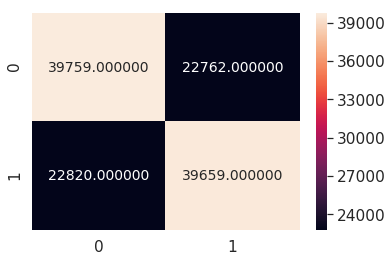

In [14]:
import seaborn as sn

df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True,fmt='f',annot_kws={"size": 14})# font size

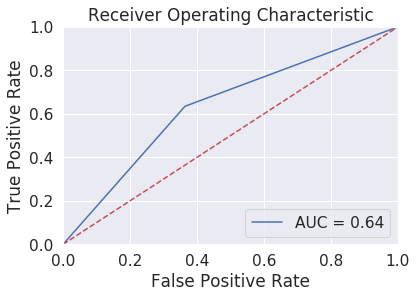

In [15]:
# ROC Curve
# plot no skill
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
